In [1]:
import torch
from torch import nn
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torchvision.transforms as transforms
import random
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm.auto import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from torchvision.transforms import ColorJitter

import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline


In [2]:
PATH = './'
TRAIN = 'train_v2/'
TEST = 'test_v2/'
SEGMENTATION = 'train_ship_segmentations_v2.csv'
DETECTION_TEST_PRED = 'ship_detection.csv'

In [3]:
train_dpath = 'train_v2/'
anno_path = 'train_ship_segmentation_v2.csv'
excluded_filenames = ['6384c3e78.jpg', ]
original_img_size = (768, 768)

In [4]:
annos = pd.read_csv('train_ship_segmentations_v2.csv')

In [5]:
annos['EncodedPixels_flag'] = annos['EncodedPixels'].map(lambda x: 1 if isinstance(x,str) else 0)

In [7]:
def decode_mask(mask, shape=(768, 768)):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] +1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    if not isinstance(mask_rle, str):
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    im = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        im[lo:hi] = 1
    return im.reshape(shape).T

In [8]:
imgs = annos.groupby('ImageId').agg({'EncodedPixels_flag':'sum'}).reset_index().rename(columns={'EncodedPixels_flag':'ships'})

In [9]:
annos['EncodedPixels_flag'] = annos['EncodedPixels'].map(lambda x: 1 if isinstance(x,str) else 0)

In [10]:
imgs_w_ships = imgs[imgs['ships'] > 0].tail(15_000)
imgs_wo_ships = imgs[imgs['ships'] == 0].tail(30_000)

selected_imgs = pd.concat([imgs_wo_ships,imgs_w_ships])
selected_imgs['target'] = selected_imgs['ships'] >0

In [11]:
train_imgs, val_imgs = train_test_split(selected_imgs,test_size=0.15,stratify=selected_imgs['target'],random_state=123) 

In [12]:
train_imgs, val_imgs = train_test_split(selected_imgs,test_size=0.15,stratify=selected_imgs['target'],random_state=123) 

train_fnames = train_imgs['ImageId'].values
val_fnames = val_imgs['ImageId'].values
train_tar = train_imgs['target'].values
val_tar = val_imgs['target'].values

test_fnames = pd.read_csv('sample_submission_v2.csv')['ImageId'].values
#p ,train_fnames =  train_test_split(train_fnames,test_size=0.1,random_state=123)
#p_1,val_fnames =  train_test_split(val_fnames,test_size=0.1,random_state=123)
print(f"""Train = {len(train_fnames)} val  = {len(val_fnames)} """)

Train = 38250 val  = 6750 


In [13]:
class ImgDataset(Dataset):

    def __init__(self,
                 img_dpath,
                 img_fnames,
                 img_transform,
                 tar):
        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.tar = tar

    def __getitem__(self, i):
        # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        img = Image.open(fpath)
           
        img = self.img_transform(img)
        if self.tar is None:
            return img,img,self.img_fnames[i]
        return img, self.tar[i],self.img_fnames[i]

    def __len__(self):
        return len(self.img_fnames)

In [14]:
def get_mask_encodings(annos,fnames):
    a = annos[annos['ImageId'].isin(fnames)]
    return a.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).to_dict()

In [15]:
class params:
    img_size = (224,224)
    bs = 30
    num_workers = 4
    lr = 0.001
    epochs = 100
    unet_depth = 5
    unet_start_filters = 8
    log_interval = 70

In [16]:
from torchvision.transforms import *
train_tfms = transforms.Compose([transforms.Resize(params.img_size),transforms.CenterCrop(params.img_size),
                                 ColorJitter(1, 1, 1),
                                 transforms.ToTensor()])
val_tfms = transforms.Compose([transforms.Resize(params.img_size),ColorJitter(1, 1,1),
                               transforms.ToTensor()])
test_tfms =transforms.Compose([transforms.Resize(params.img_size),ColorJitter(1, 1, 1),
                               transforms.ToTensor()])

In [17]:
train_ds = ImgDataset(train_dpath, train_fnames, train_tfms, train_tar)
val_ds = ImgDataset(train_dpath, val_fnames, val_tfms, val_tar)
test_ds = ImgDataset(TEST, test_fnames, val_tfms, None)

In [18]:
sns.set_style(style='white')

def show_images(dataset):
    np.random.seed(0)
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        print(idx)
        img, label,_ = dataset[idx]
        fig_x.set_title(_)
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

2732
1653
4931
5827
1033
4373


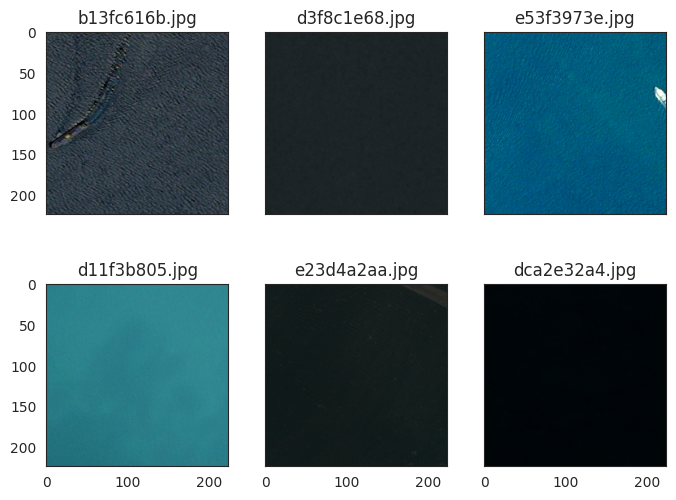

In [19]:
show_images(train_ds)

In [20]:
!ls

 airbus-ship-detection.zip	      Semantic.ipynb
 Classification.ipynb		     'Semantic Segmentation-Copy1.ipynb'
'Classification Resnet-Copy1.ipynb'  'Semantic Segmentation.ipynb'
'Classification Resnet.ipynb'	      sub.csv
 final				      submission.csv
 final.csv			      test_v2
 Model.ipynb			      train_ship_segmentations_v2.csv
 prob.csv			      train_v2
 resnet34-333f7ec4.pth		      unet_final
 Resnet-Copy1.ipynb		      Unet.ipynb
 Resnet.ipynb			      Untitled.ipynb
 sample_submission_v2.csv


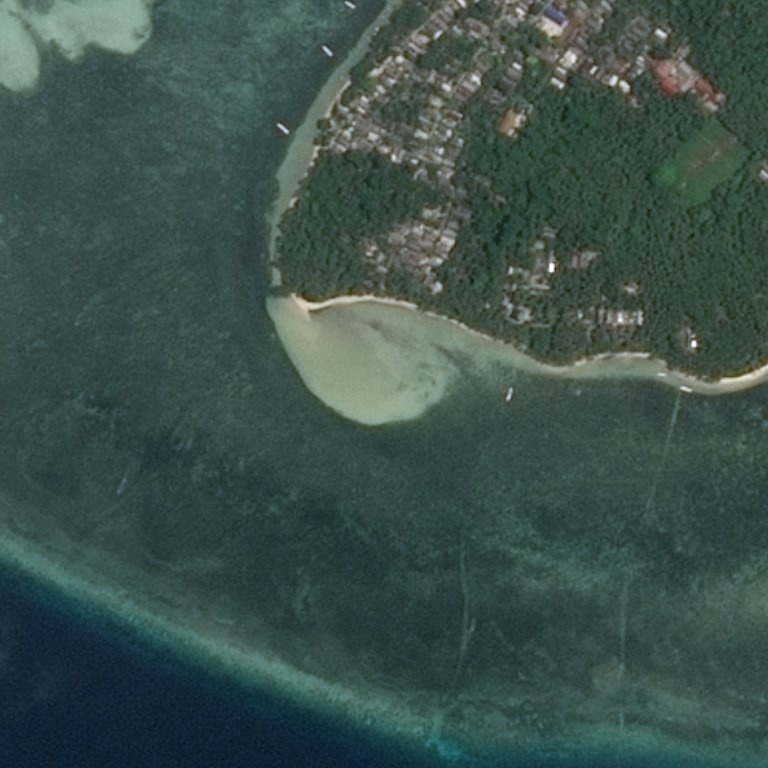

In [21]:
Image.open('train_v2/090866706.jpg')

# Model

In [22]:
import torchvision as tv
model = tv.models.resnet34(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:

model.fc = nn.Sequential(nn.Linear(512,1),nn.Sigmoid())

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.

In [25]:
optimizer = torch.optim.Adam(params_to_update)


In [26]:
train_dl = DataLoader(train_ds,
                      batch_size=256,
                      shuffle=True)
val_dl = DataLoader(val_ds,
                    batch_size=256,
                    shuffle=False)
test_dl = DataLoader(test_ds,
                    batch_size=256,
                    shuffle=False)

In [27]:
torch.cuda.empty_cache()
from sklearn.metrics import precision_score, recall_score

In [28]:
def Acc(model,data):
    torch.cuda.empty_cache()
    acc_sum,recall_sum,pres_sum = 0.0,0.0,0.0
    
    model.eval()
    n = 0

    for X,y,_ in data:


        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        y_pred = torch.where(y_pred.reshape(-1) > 0.5 ,torch.tensor(1),torch.tensor(0))
        acc_sum += (y_pred== y).sum().item()

        n += y.shape[0]

    return acc_sum/n

#  Train

In [ ]:
torch.cuda.empty_cache()
dev = 'cuda'
device='cuda'
model = model.to(dev)
model = model.to(dev)

criterion = nn.BCELoss()
for epoch in tqdm(range(30)):
    model.train()
    for i , (X,y,_) in enumerate(train_dl):

        optimizer.zero_grad()
        y = y.to(dev)
        X = X.to(dev)   
        y_pred = model(X)
        loss = criterion(y_pred.reshape(-1),y.float())
        loss.backward()
        optimizer.step()
        print(loss.item())
    if epoch %10 == 0:
        print('Accuracy = ', Acc(model,val_dl) )
        
        
        

  0%|          | 0/30 [00:00<?, ?it/s]

0.6420824527740479
5.347772598266602
2.414078950881958
1.445988655090332
1.2082141637802124
0.7869797945022583
0.7865928411483765
0.7200263738632202
0.707061767578125
0.6772094368934631
0.6087725162506104
0.6276271343231201
0.6065210103988647
0.647885799407959
0.5935860276222229
0.6273032426834106
0.583734393119812
0.5860264301300049
0.598151445388794
0.6025064587593079
0.640785813331604
0.626350462436676
0.6056562662124634
0.6164493560791016
0.5949591398239136
0.6032938957214355
0.5892842411994934
0.5999332070350647
0.5947595834732056
0.6126906275749207
0.5456584692001343
0.6405212879180908
0.6406519412994385
0.5728108882904053
0.5716913938522339
0.5842121839523315
0.5963878035545349
0.6499253511428833
0.5429213643074036
0.6048557162284851
0.5406874418258667
0.5674643516540527
0.5523169636726379
0.5838197469711304
0.6057933568954468
0.5832524299621582
0.6603571772575378
0.6602803468704224
0.6165509819984436
0.5892572999000549
0.6189417243003845
0.6186506748199463
0.6204016804695129
0.

0.5581748485565186
0.6261491775512695
0.5741560459136963
0.596398651599884
0.5618319511413574
0.5306921005249023
0.5364470481872559
0.5631533861160278
0.5769530534744263
0.5657864809036255
0.5624294281005859
0.5869572758674622
0.5399301648139954
0.5639163255691528
0.5942932963371277
0.588031530380249
0.5527083277702332
0.5340925455093384
0.5570208430290222
0.5719165802001953
0.5357726812362671
0.5876327157020569
0.5478366613388062
0.5829103589057922
0.5531398057937622
0.5222474336624146
0.5585993528366089
0.5854198932647705
0.5402389764785767
0.5884759426116943
0.5320391654968262
0.5558344125747681
0.5629682540893555
0.541763961315155
0.5686962008476257
0.6188392639160156
0.5581092834472656
0.5762614011764526
0.5687851905822754
0.540573000907898
0.5302850008010864
0.5638132095336914
0.5537124872207642
0.5501077175140381
0.5695905685424805
0.5444251298904419
0.5695961713790894
0.5597410798072815
0.5786969661712646
0.6045928001403809
0.5689246654510498
0.5667493343353271
0.57203429937362

0.353171706199646
0.404407799243927
0.44065049290657043
0.3550024628639221
0.3812924027442932
0.3815550208091736
0.3811625838279724
0.42350977659225464
0.4229980707168579
0.35104331374168396
0.34610897302627563
0.38225412368774414
0.3234385550022125
0.3698314130306244
0.33534833788871765
0.37872135639190674
0.3534693121910095
0.3656500577926636
0.2818673253059387
0.3343333601951599
0.32921379804611206
0.3073872923851013
0.34015628695487976
0.36454349756240845
0.3423807621002197
0.42198804020881653
0.35147443413734436
0.34443432092666626
0.3488447070121765
0.37714308500289917
0.2802615165710449
0.27138012647628784
0.3367985188961029
0.39544251561164856
0.3305699825286865
0.33385375142097473
0.3319965600967407
0.37499159574508667
0.2741711139678955
0.36269646883010864
0.3086795508861542
0.3063752055168152
0.31258976459503174
0.3499789535999298
0.29712074995040894
0.36381179094314575
0.32461410760879517
0.30593717098236084
0.2865253686904907
0.25696536898612976
0.31694960594177246
0.36957

0.2788875699043274
0.3265071511268616
0.24253296852111816
0.24222978949546814
0.32940900325775146
0.31724637746810913
0.2933574318885803
0.2605937123298645
0.2919938564300537
0.308685839176178
0.2740623950958252
0.31521350145339966
0.28104138374328613
0.2719842791557312
0.2696066200733185
0.2883837819099426
0.28318625688552856
0.3202221095561981
0.26900193095207214
0.28421491384506226
0.2195717692375183
0.26235416531562805
0.30244290828704834
0.23850809037685394
0.28284770250320435
0.2819650173187256
0.25655245780944824
0.23008191585540771
0.29008737206459045
0.3055647015571594
0.322400838136673
0.24027597904205322
0.26887667179107666
0.2724078297615051
0.2991071343421936
0.25298401713371277
0.21405816078186035
0.259974867105484
0.3105621337890625
0.25234827399253845
0.30725157260894775
0.28502461314201355
0.30538201332092285
0.4161771535873413
0.309951514005661
0.30207598209381104
0.34026965498924255
0.24903565645217896
0.252978652715683
0.2823968827724457
0.31725162267684937
0.236295

In [37]:
Acc(model,val_dl)

0.9071111111111111

In [45]:
torch.cuda.empty_cache()

In [38]:
torch.save(model,'resnet34')

# Test

In [40]:
torch.cuda.empty_cache()
dev = 'cuda'
model = model.to(dev)
model.eval()
final = pd.DataFrame()
for i, (X, _,name) in enumerate(test_dl):
    tmp  =pd.DataFrame()
    X = Variable(X).to(dev)   
    y_pred = model(X)
    tmp['ImageId']=name
    
  
    tmp['ship'] = y_pred.detach().to('cpu')
    final = pd.concat([final,tmp],ignore_index=True)

In [41]:
final.to_csv('prob.csv')